In [111]:
from PYME.IO.image import ImageStack
from detector import Detector
import matplotlib.pyplot as plt
# %matplotlib widget
# plt.set_loglevel("warning")
import numpy as np
import os
from PYME.recipes.processing import BackgroundSubtractionMovingPercentile

In [112]:
mac_path = '/Users/andy/Library/CloudStorage/GoogleDrive-aesb@stanford.edu/Shared drives/WEMpire-Users-TEMPONLY/AESB/From Ashwin  DHPSF Data'
im = ImageStack(filename=os.path.join(mac_path, "FOV2_ER_500mW_647_p02exp_Gain300_X2.tif"), haveGUI=False)
im.mdh['Camera.NoiseFactor'] = 1.4 # typical for EMCCD with gain > 10
im.mdh['Camera.ElectronsPerCount'] = 12.9  # e-/ADU
im.mdh['Camera.TrueEMGain'] = 272
im.mdh['Camera.ADOffset'] = 110 # [ADU]
im.mdh['voxelsize.x'] = 0.1175 # [um]
im.mdh['voxelsize.y'] = 0.1175 # [um]

dark = ImageStack(filename=os.path.join(mac_path, "RedChannelSR_Dark_Counts.tif"), haveGUI=False)

filename == /Users/andy/Library/CloudStorage/GoogleDrive-aesb@stanford.edu/Shared drives/WEMpire-Users-TEMPONLY/AESB/From Ashwin  DHPSF Data/FOV2_ER_500mW_647_p02exp_Gain300_X2.tif
/Users/andy/Library/CloudStorage/GoogleDrive-aesb@stanford.edu/Shared drives/WEMpire-Users-TEMPONLY/AESB/From Ashwin  DHPSF Data/FOV2_ER_500mW_647_p02exp_Gain300_X2.tif
(12446, 293, 293)
[293, 293, 12446, 1, 1]
filename == /Users/andy/Library/CloudStorage/GoogleDrive-aesb@stanford.edu/Shared drives/WEMpire-Users-TEMPONLY/AESB/From Ashwin  DHPSF Data/RedChannelSR_Dark_Counts.tif
/Users/andy/Library/CloudStorage/GoogleDrive-aesb@stanford.edu/Shared drives/WEMpire-Users-TEMPONLY/AESB/From Ashwin  DHPSF Data/RedChannelSR_Dark_Counts.tif
(246, 293, 293)
[293, 293, 246, 1, 1]


In [113]:
bg_sub = BackgroundSubtractionMovingPercentile().apply_simple(im)

In [128]:
lobe_sep = 800  # [nm]
lobe_sep_px = lobe_sep / im.mdh.voxelsize_nm.x
print(lobe_sep_px)

6.808510638297872


8
16


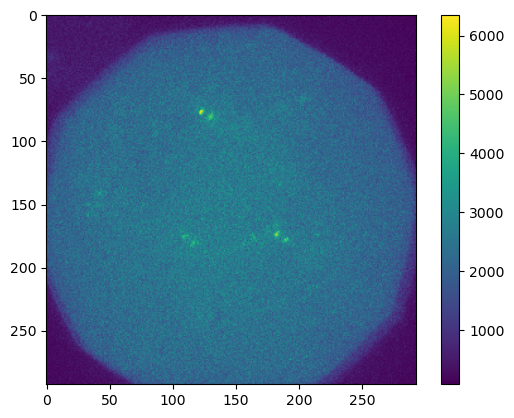

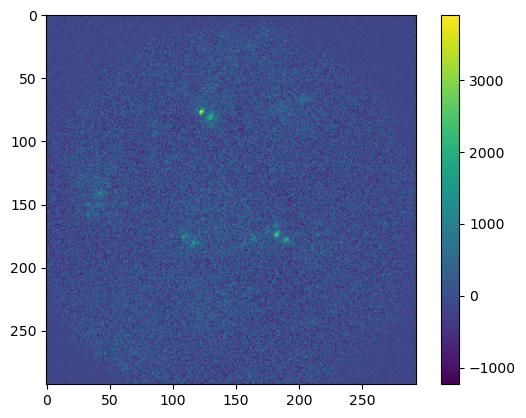

In [156]:
test_frame = 75#40
plt.figure()
plt.imshow(im.data_xytc[:,:,test_frame,0])
plt.colorbar()

plt.figure()
plt.imshow(bg_sub.data_xytc[:,:,test_frame,0])
plt.colorbar()

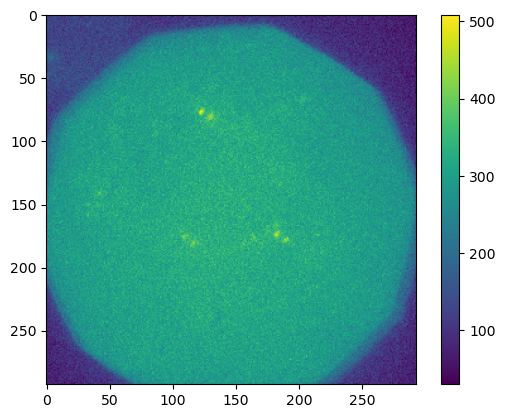

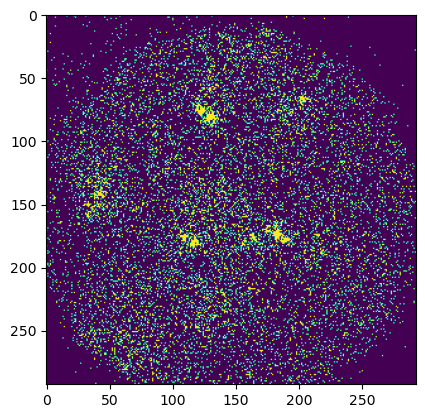

In [157]:
from PYME.localization.remFitBuf import fitTask

sigma = fitTask.calcSigma(im.mdh, (im.data_xytc[:,:,test_frame,0] - im.mdh['Camera.ADOffset']).astype('f'))

plt.figure()
plt.imshow(sigma)
plt.colorbar()

plt.figure()
plt.imshow(bg_sub.data_xytc[:,:,test_frame,0] > sigma)

In [158]:
detector = Detector(im.data_xytc.shape[:2], 15, mag=0.15)

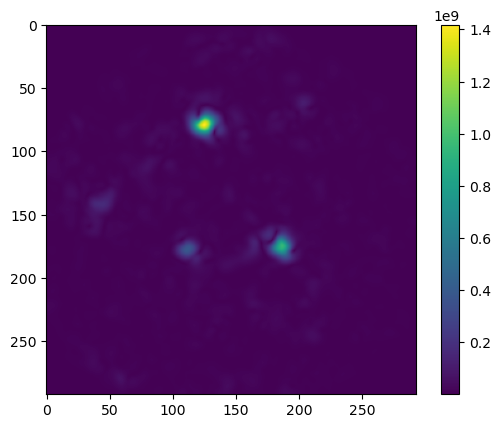

In [159]:

# plt.figure()
# plt.imshow(im.data_xytc[:,:,test_frame,0])
# plt.colorbar()

strength_image, angle_image = detector.filter_frame(np.asarray(bg_sub.data_xytc[:,:,test_frame,0].squeeze(), dtype=float))

plt.figure()
plt.imshow(strength_image)
plt.colorbar()

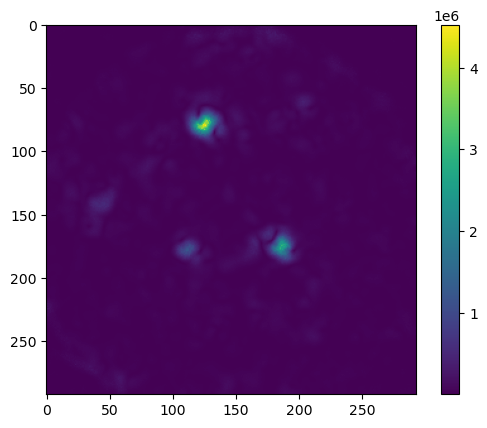

In [160]:
plt.figure()
plt.imshow(strength_image / sigma.squeeze())
plt.colorbar()

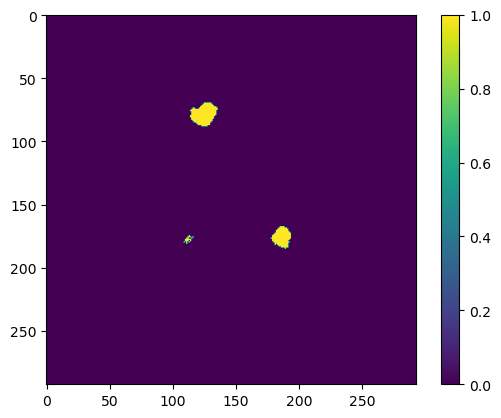

In [161]:
plt.figure()
plt.imshow(strength_image > 1E6 * sigma.squeeze())
plt.colorbar()

In [162]:
row, col, orientation = detector.extract_candidates(strength_image, angle_image, 1E6 * sigma.squeeze())

In [163]:
row

array([ 79, 175, 178])

In [164]:
col
orientation

array([0.62017538, 0.64142667, 0.73246928])

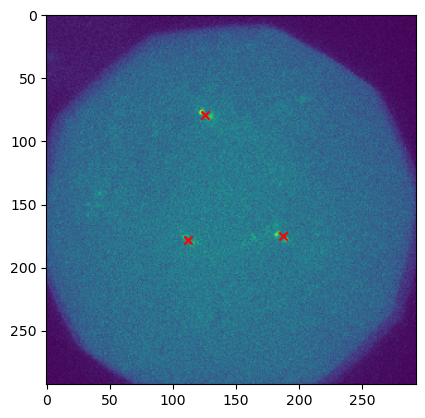

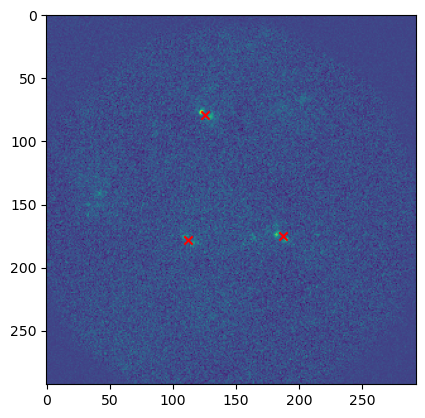

In [165]:
plt.figure()
plt.imshow(im.data_xytc[:,:,test_frame,0])
plt.scatter(col, row, marker='x', c='red')
plt.show()

plt.figure()
plt.imshow(bg_sub.data_xytc[:,:,test_frame,0])
plt.scatter(col, row, marker='x', c='red')
plt.show()

Text(0.5, 1.0, 'Orientation Map [radians]')

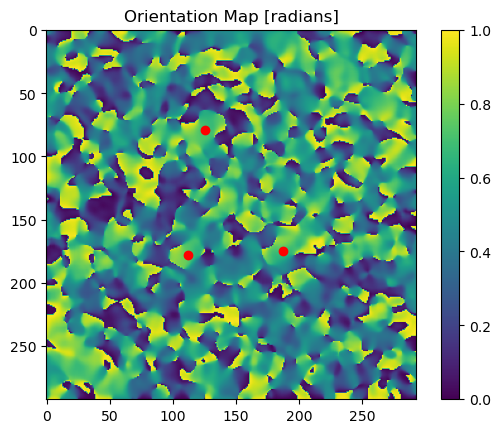

In [166]:
plt.figure()
plt.imshow(angle_image)
plt.scatter(col, row, c='r')
plt.colorbar()
plt.title('Orientation Map [radians]')

In [167]:
def lobe_estimate_from_center_pixel(x_pix, y_pix, orientation, lobe_sep_px):
    dx = np.cos(orientation) * lobe_sep_px
    dy = np.sin(orientation) * lobe_sep_px
    x1 = x_pix - dx
    y1 = y_pix - dy
    x2 = x_pix + dx
    y2 = y_pix + dy
    return x1, y1, x2, y2

x1, y1, x2, y2 = lobe_estimate_from_center_pixel(col, row, orientation, lobe_sep_px)

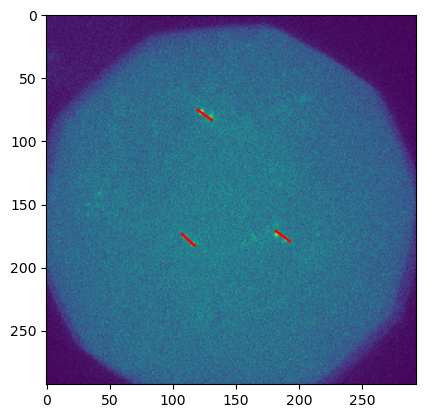

In [168]:
plt.figure()
plt.imshow(im.data_xytc[:,:,test_frame,0])
# plt.scatter(col, row, marker='x', c='red')
for ii in range(len(row)):
    plt.plot([x1, x2], [y1, y2], 'r')

plt.show()